In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py as h5
import sys
from scipy.stats import binned_statistic
from scipy.stats.mstats import theilslopes
from importlib import reload
from pathlib import Path

sys.path.append('/reg/neh/home4/espov/python/datastorage/')
import datastorage

import ana_fun as ana
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rc('font', size=14)

Loading BokehJS ...

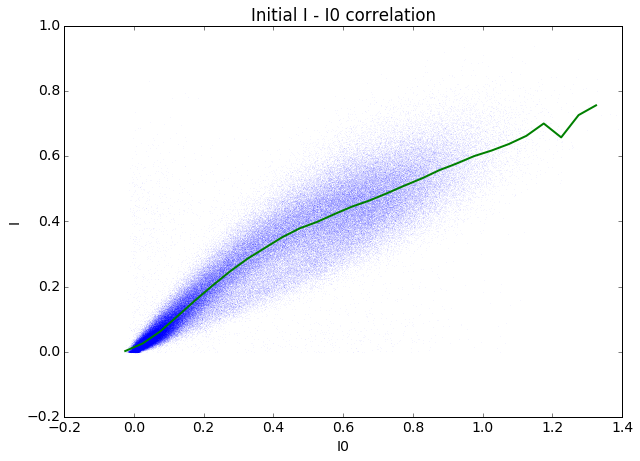

In [2]:
data = datastorage.read('vesp_run60_anaMPI.h5')
ttdata = datastorage.read('ttdata.h5')

t0 = 51.75
pixel_to_femtosecond = 0.0033444

mask = np.logical_and(~np.isnan(data.sig), ~np.isnan(data.I0))

dl = -(data.dl[mask]-t0)
I0 = data.I0[mask]*1000
I = data.sig[mask]
energy = data.ebeam.photon_energy[mask]
energyL3 = data.ebeam.L3_energy[mask]

dl.shape

plt.figure('I0 correlation')
plt.title('Initial I - I0 correlation')
plt.plot(I0, I, '.', markersize=0.05)
plt.xlabel('I0')
plt.ylabel('I')

bins = np.arange(-0.1,1.4,0.05)
med = binned_statistic(I0, I, bins=bins, statistic='median').statistic
xmed = bins[:-1]+np.diff(bins)/2
plt.plot(xmed, med, linewidth=2)
plt.show()

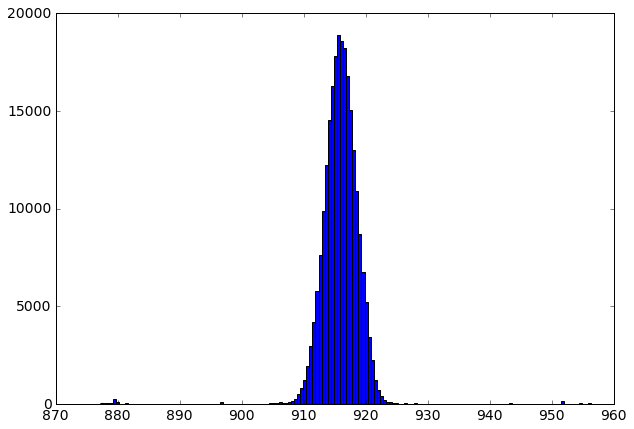

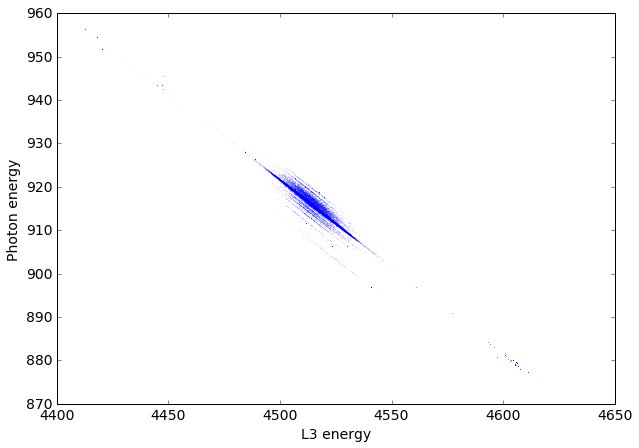

In [3]:
plt.hist(energy, bins=160)

plt.figure()
plt.plot(energyL3, energy, '.', markersize=0.1)
plt.xlabel('L3 energy')
plt.ylabel('Photon energy')
plt.show()

Why is the correlation between L3 energy and photon energy negative?

### Bin according to energy

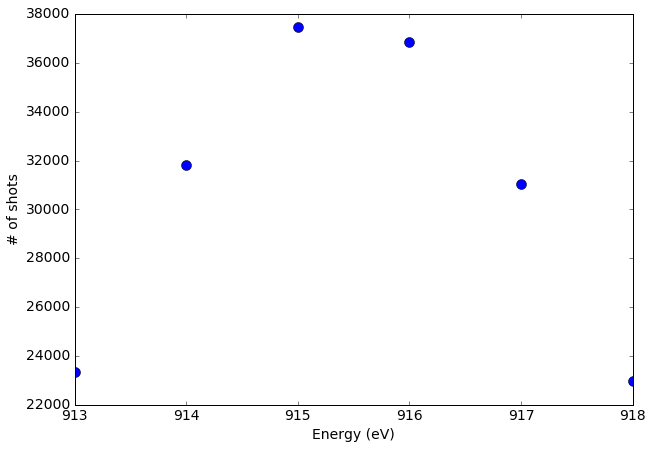

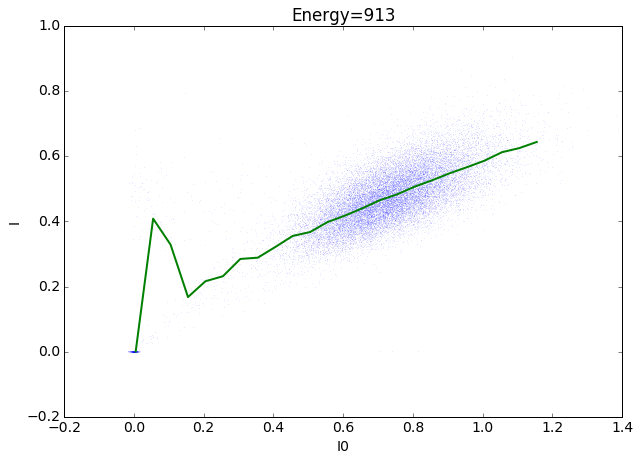

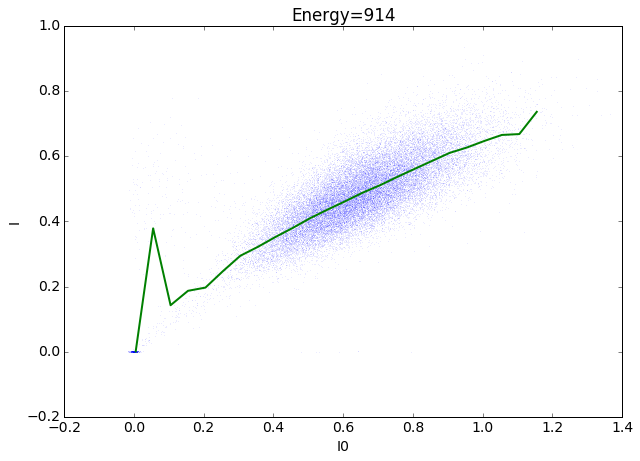

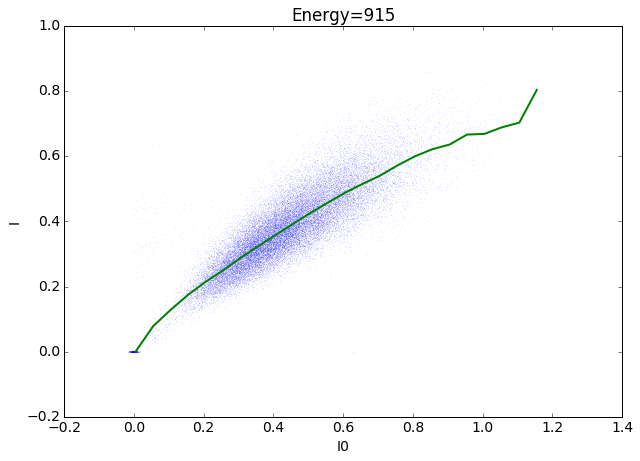

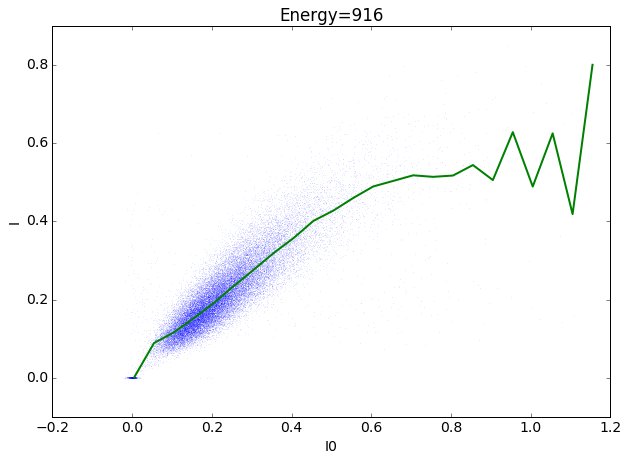

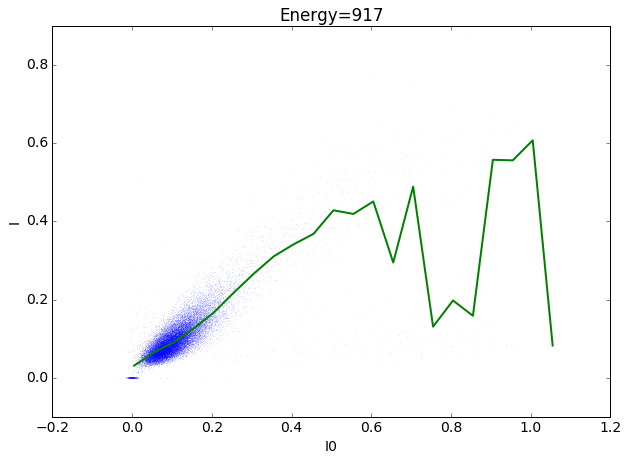

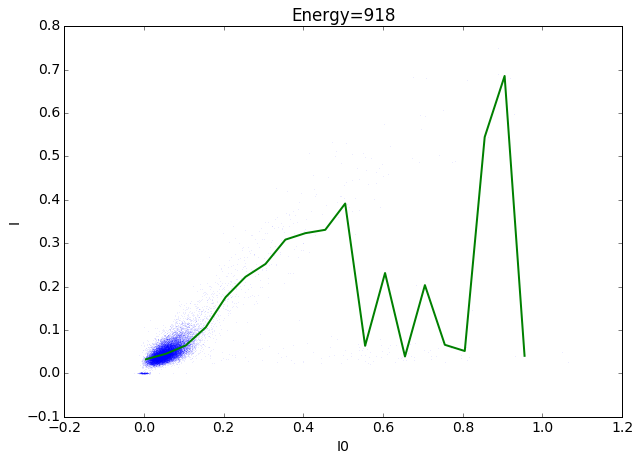

In [4]:
eBin = np.arange(913,920,1)
shot_eBin = np.digitize(energy, eBin)
shot_eBin = shot_eBin-1

shots = []
for binNb in np.unique(shot_eBin):
    shots.append(np.sum(shot_eBin==binNb))
shots = np.asarray(shots)
plt.figure()
plt.plot(eBin[:-1],shots[1:-1],'o',markersize=10)
plt.xlabel('Energy (eV)')
plt.ylabel('# of shots')

for binIdx in np.unique(shot_eBin)[1:-1]:
    inBin = shot_eBin==binIdx
    plt.figure()
    plt.title('Energy='+str(eBin[binIdx]))
    plt.plot(I0[inBin], I[inBin], '.', markersize=0.1)
    plt.xlabel('I0')
    plt.ylabel('I')
    
    bins = np.arange(-0.02,1.2,0.05)
    med = binned_statistic(I0[inBin], I[inBin], bins=bins, statistic='median').statistic
    xmed = (bins[1:] + bins[:-1]) / 2
    plt.plot(xmed, med, linewidth=2)

plt.show()

I was expecting the correlation plot for small energy range to be much better correlated. Why isn't it the case? Doesn't that mean that the energy correction is not meaningful? What is the energy correction really doing then?

### Analyze data for E=915

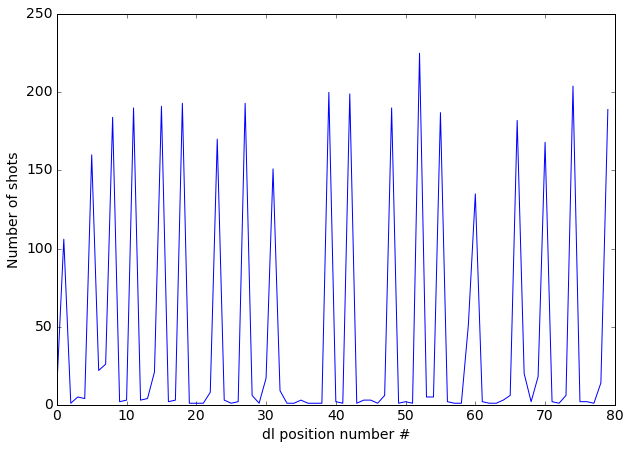

In [5]:
anaBin = 2
mask = shot_eBin==anaBin
dl_eBin = dl[mask]
I_eBin = I[mask]
I0_eBin = I0[mask]

shots = []
for t in np.unique(dl_eBin)[:80]:
    shots.append(np.sum(dl_eBin==t))

shots = np.asarray(shots)
plt.figure()
plt.plot(shots)
plt.xlabel('dl position number #')
plt.ylabel('Number of shots')
plt.show()

#### Filter dl with low shots

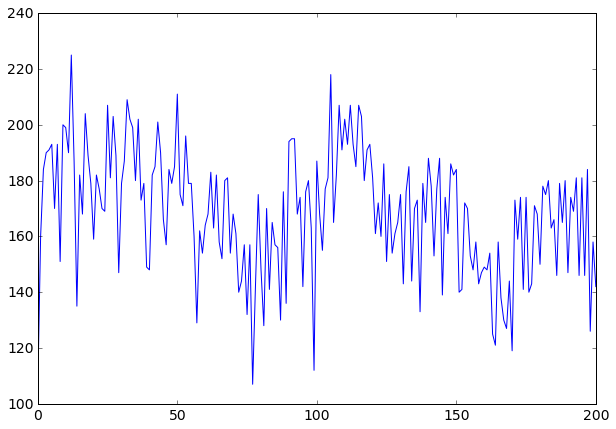

In [6]:
dl_mask = np.zeros(len(dl_eBin))
shots = []
for t in np.unique(dl_eBin):
    shot = np.sum(t==dl_eBin)
    if shot > 80:
        dl_mask = np.logical_or(dl_mask, (t==dl_eBin))
        shots.append(shot)
shots = np.asarray(shots)

dl_eBin = dl_eBin[dl_mask]
I_eBin = I_eBin[dl_mask]
I0_eBin = I0_eBin[dl_mask]

plt.figure()
plt.plot(shots)
plt.show()

#### I0 filter

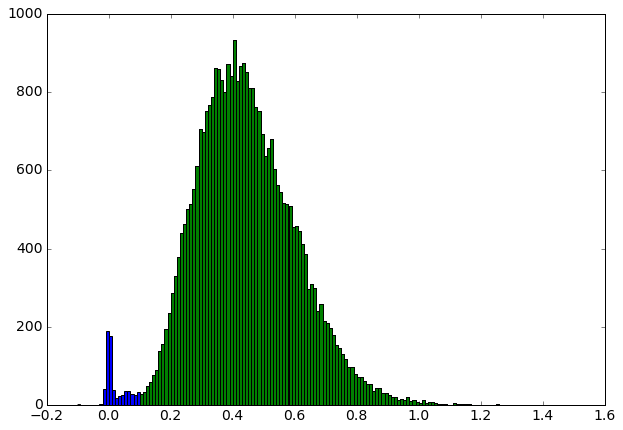

In [7]:
bins=np.arange(-0.1,1.5,0.01)
plt.hist(I0_eBin, bins=bins)

I0filt = 0.1
I0mask = I0_eBin>I0filt

dl_eBin = dl_eBin[I0mask]
I0_eBin = I0_eBin[I0mask]
I_eBin = I_eBin[I0mask]

plt.hist(I0_eBin, bins=bins)
plt.show()

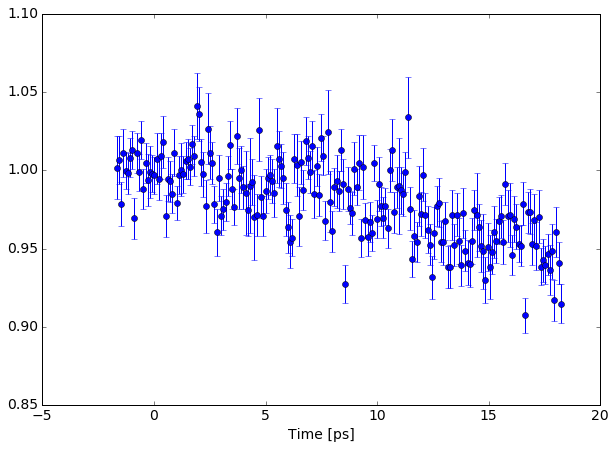

In [8]:
time = np.unique(dl_eBin)/0.15
Inorm = I_eBin/I0_eBin
Iave = []
Ierr = []
for t in np.unique(dl_eBin):
    Iave.append(np.mean(Inorm[dl_eBin==t]))
    count = np.sum(Inorm[dl_eBin==t])
    Ierr.append( np.std(Inorm[dl_eBin==t]) / np.sqrt(count) )

Iave = np.asarray(Iave)
Iave = Iave / np.mean(Iave[(np.unique(dl_eBin)<0)])
Ierr = np.asarray(Ierr)
plt.errorbar(time, Iave, Ierr, marker='o', linestyle='None')
plt.xlabel('Time [ps]')
plt.show()